In [1]:
import os
import pickle
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import utils

from model import GFR
from evaluate import explained_variance_ratio
from data import get_data, get_train_test_data, preprocess_data

pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.3f}'.format

/Users/calvin/miniforge3/envs/allen/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/calvin/miniforge3/envs/allen/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E736BB25-B038-3AFE-BCF3-8026B5D2C7B6> /Users/calvin/miniforge3/envs/allen/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <F19B5356-08DC-327C-8EE1-6C5127508CD0> /Users/calvin/miniforge3/envs/allen/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
def get_params(bin_size, activation_bin_size, C):
    params = {}
    save_path = f"model/params/{bin_size}_{activation_bin_size}_{C}/"
    for fname in os.listdir(save_path):
        if fname.endswith(".pickle"):
            cell_id = int(fname.split(".")[0])
            with open(f"{save_path}{fname}", "rb") as f:
                params[cell_id] = pickle.load(f)
    return params

def get_all_params():
    bin_sizes = [10, 20, 50, 100]
    activation_bin_sizes = [20, 100]
    C = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0]
    
    params = {}
    
    for bin_size in bin_sizes:
        for activation_bin_size in activation_bin_sizes:
            if activation_bin_size >= bin_size:
                for c in C:
                    params[(bin_size, activation_bin_size, c)] = get_params(bin_size, activation_bin_size, c)
                                
    return params

# summarize params of one configuration
def summarize(params):
    data = {"cell_id": [], "evr1": [], "evr2": [], "loss": [], "epochs": []}

    for cell_id in params:
        data["cell_id"].append(cell_id)
        data["evr1"].append(params[cell_id]["evr1"])
        data["evr2"].append(params[cell_id]["evr2"])
        data["loss"].append(params[cell_id]["train_losses"][-1])
        data["epochs"].append(len(params[cell_id]["train_losses"]))

    df = pd.DataFrame(data)
    df = df.set_index("cell_id")
    df = df.sort_values("evr2")
    df_corrected = df[df["evr1"] > 0.01].dropna()
    
    if len(df) == 0:
        return {}
    
    return {
        "n_cells": len(df),
        "p_zero_evr": len(df[df['evr2'] < 0.01]) / len(df),
        "p_early_stop": len(df[df['epochs'] < 50]) / len(df),
        "corrected_median_evr": np.median(df_corrected['evr2'].values)
    }

def get_best_params_for_actv_bin_size(params, bin_size, actv_bin_size):
    best_params = {}
    
    cell_ids = set()
    for config in params:
        cell_ids = cell_ids.union(set(params[config].keys()))
    
    for cell_id in cell_ids:
        best_config = None
        best_evr = -1e10
        
        for config in params:
            if config[0] == bin_size and config[1] == actv_bin_size and cell_id in params[config] and params[config][cell_id]["evr1"] > best_evr:
                best_evr = params[config][cell_id]["evr1"]
                best_config = config
        
        # doesn't make sense
        if best_config is not None:
            best_params[cell_id] = params[best_config][cell_id]
        
    return best_params

def get_best_params(params, bin_size):
    best_params = {}
    
    cell_ids = set()
    for config in params:
        cell_ids = cell_ids.union(set(params[config].keys()))
    
    for cell_id in cell_ids:
        best_config = None
        best_evr = -1e10
        
        for config in params:
            if config[0] == bin_size and cell_id in params[config] and params[config][cell_id]["evr1"] > best_evr:
                best_evr = params[config][cell_id]["evr1"]
                best_config = config
        
        # doesn't make sense
        if best_config is not None:
            best_params[cell_id] = params[best_config][cell_id]
        
    return best_params

# summarize params of one configuration
def summarize(params):
    data = {"cell_id": [], "evr1": [], "evr2": [], "loss": [], "epochs": []}

    for cell_id in params:
        data["cell_id"].append(cell_id)
        data["evr1"].append(params[cell_id]["evr1"])
        data["evr2"].append(params[cell_id]["evr2"])
        data["loss"].append(params[cell_id]["train_losses"][-1])
        data["epochs"].append(len(params[cell_id]["train_losses"]))

    df = pd.DataFrame(data)
    df = df.set_index("cell_id")
    df = df.sort_values("evr2")
    df_corrected = df[df["evr1"] > 0.01].dropna()
    
    if len(df) == 0:
        return {}
    
    return {
        "n_cells": len(df),
        "p_zero_evr": len(df[df['evr2'] < 0.01]) / len(df),
        "p_early_stop": len(df[df['epochs'] < 50]) / len(df),
        "corrected_median_evr": np.median(df_corrected['evr2'].values)
    }

def visualize_data(params):
    data = {"cell_id": [], "evr1": [], "evr2": [], "loss": [], "epochs": []}

    for cell_id in params:
        data["cell_id"].append(cell_id)
        data["evr1"].append(params[cell_id]["evr1"])
        data["evr2"].append(params[cell_id]["evr2"])
        data["loss"].append(params[cell_id]["train_losses"][-1])
        data["epochs"].append(len(params[cell_id]["train_losses"]))

    df = pd.DataFrame(data)
    df = df.set_index("cell_id")
    df = df.sort_values("evr2")

    print(f"Total number of cells: {len(df)}")
    print(f"Number/proportion of cells with evr<=0: {len(df[df['evr2'] <= 0])}/{len(df[df['evr2'] <= 0]) / len(df)}")
    print(f"Number/proportion of cells with epochs<50: {len(df[df['epochs'] < 50])}/{len(df[df['epochs'] < 50]) / len(df)}")

    df_corrected = df[df["evr1"] > 0.01]
    print(f"Median evr: {np.median(df_corrected.dropna()['evr2'].values)}")

    evrs1 = df_corrected.iloc[:, 0]
    evrs2 = df_corrected.iloc[:, 1]
    losses = df_corrected.iloc[:, 2]

    plt.figure()
    plt.hist(evrs2, bins="auto")
    plt.xlabel("evr2")
    plt.ylabel("counts")
    plt.title("evr2 histogram (failed optimizations removed)")

    
    plt.figure()
    plt.hist(losses, bins="auto")
    plt.xlabel("loss")
    plt.ylabel("counts")
    plt.title("loss histogram (failed optimizations removed)")

    plt.figure()
    plt.scatter(evrs2, losses, alpha=0.5)
    plt.xlabel("evr2")
    plt.ylabel("loss")
    plt.title("evr2 vs loss scatter plot (failed optimizations removed)")

    plt.figure()
    plt.scatter(evrs1, evrs2, alpha=0.5)
    plt.xlabel("evr1")
    plt.ylabel("evr2")
    plt.title("evr1 vs evr2 scatter plot (failed optimizations removed)")
    
    return df

def get_line_name(df, cell_id):
    return df[df["specimen__id"] == cell_id]["line_name"].to_numpy()[0]

In [3]:
with open("model/best_params.pickle", "rb") as f:
    params = pickle.load(f)

In [ ]:
evrs = {}
medians = []
bin_sizes = [10, 20, 50, 100]
ps = []
for bin_size in bin_sizes:
    ps.append(get_best_params(params, bin_size))
    
for i, p in enumerate(ps):
    evr = []
    for cell_id in p:
        evr.append(p[cell_id]["evr2"])
    medians.append(np.median(evr))
    evrs[f"$\\Delta t={bin_sizes[i]}$"] = evr

In [ ]:
plt.figure(figsize=(6, 3.2), dpi=1000)
plt.hist(evrs.values(), histtype='step', bins="auto", label=[f"$\\Delta t={x}$" for x in bin_sizes])
plt.xlabel("explained variance ratio");
plt.legend()
plt.show()

In [ ]:
bin_size = 20
actv_bin_size = 20
df = visualize_data(params[(bin_size, actv_bin_size)])

In [6]:
def visualize(cell_id, params, bin_size=20):
    model = GFR.from_params(params[cell_id]["params"])
    data = get_data(cell_id)
    Is_tr, fs_tr, _, _, Is_te, fs_te, stims = get_train_test_data(data, bin_size)
    Is_actv, fs_actv = preprocess_data(data, bin_size=params[cell_id]["params"]["g"]["bin_size"])
    
    def _plot_train_data():
        for Is, fs, s in zip(Is_tr, fs_tr, stims):
            if torch.sum(fs) > 0.2:
                for i in range(Is.shape[0]):
                    utils.plot_predictions(
                        model, 
                        Is[i, :], 
                        fs[i, :],
                        bin_size
                    )
                
    def _plot_noise2():
        r = explained_variance_ratio(model, Is_te[0], fs_te[0], bin_size)
        print(Is_te[0][0, :].shape)
        utils.plot_predictions(
            model, 
            Is_te[0][0, :], 
            fs_te[0][0, :], 
            bin_size, 
            xlim = [15, 20]
        )
    
    def _plot_kernel():
        utils.plot_kernel(
            model,
            cell_id,
            bin_size,
            save = False,
            xlim = 25
        )
    
    def _plot_activation():
        utils.plot_activation(
            Is_actv,
            fs_actv,
            model.g
        )
    
    def _plot_losses():
        train_losses = params[cell_id]["train_losses"]
        test_losses = params[cell_id]["test_losses"]
        plt.figure()
        plt.plot(list(range(len(train_losses))), train_losses, label="Train")
        plt.plot(list(range(len(test_losses))), test_losses, label="Test")
        plt.xlabel("Epoch")
        plt.ylabel("Poisson NLL Loss")
        plt.legend()
        
    _plot_train_data()
    _plot_noise2()
    _plot_kernel()
    _plot_activation()
    _plot_losses()

torch.Size([260])


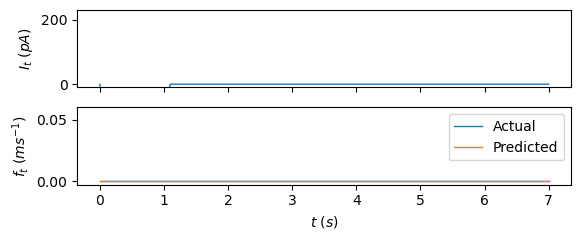

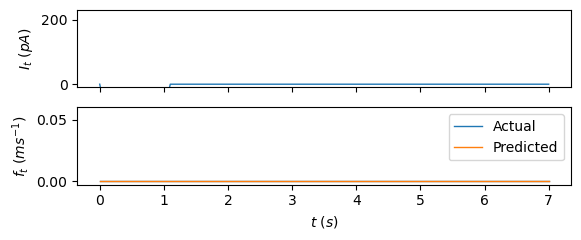

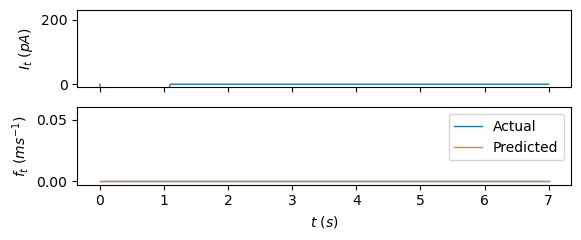

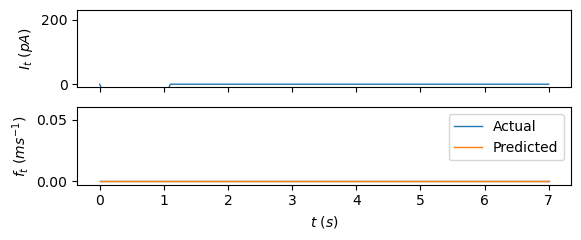

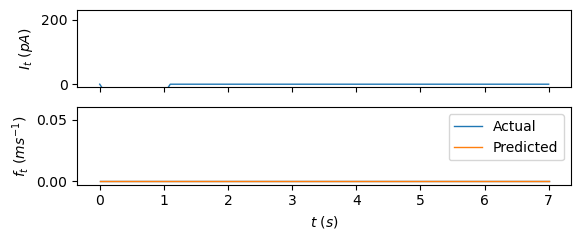

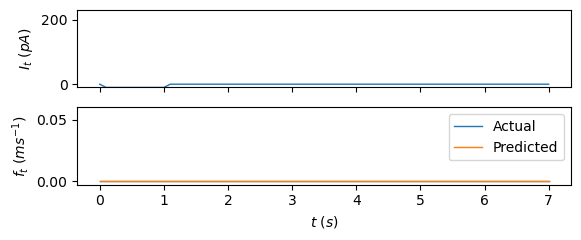

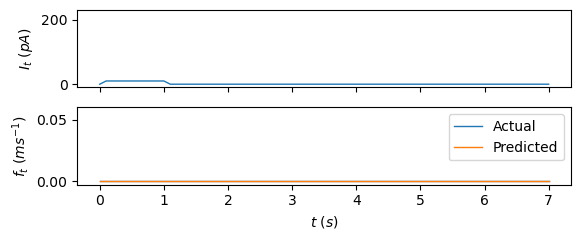

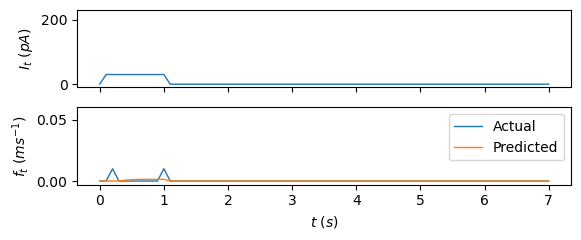

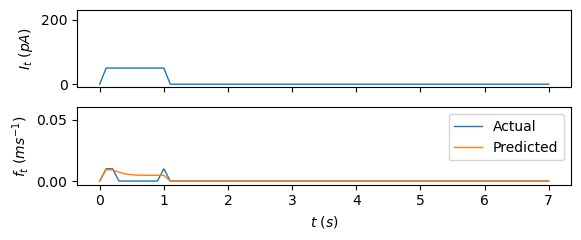

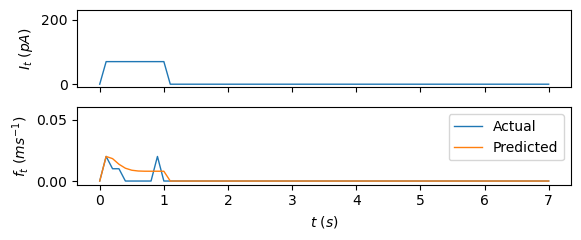

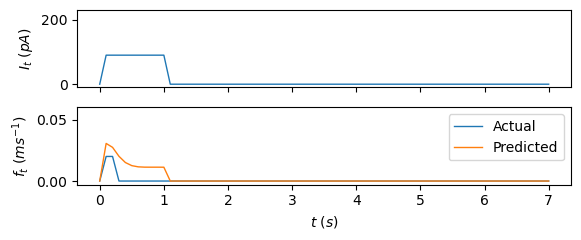

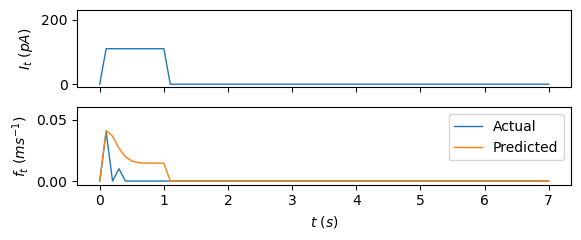

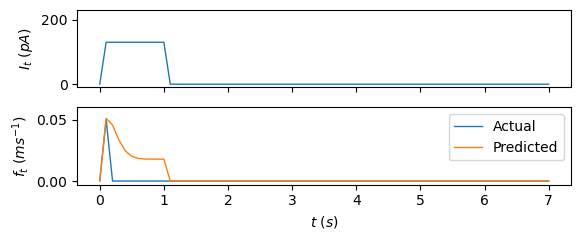

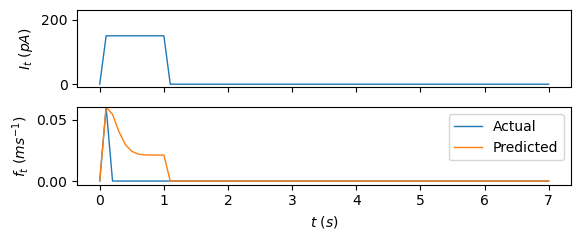

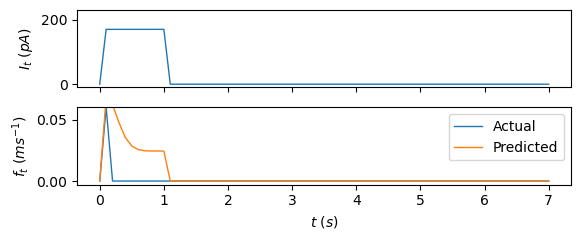

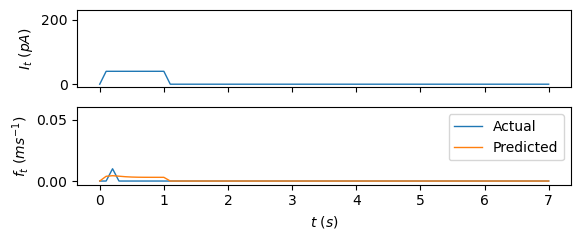

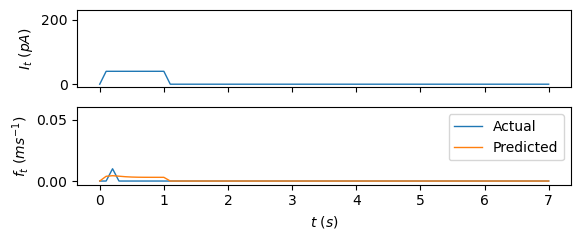

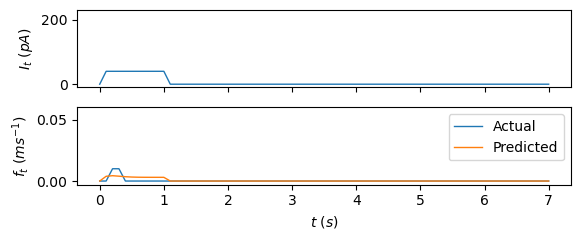

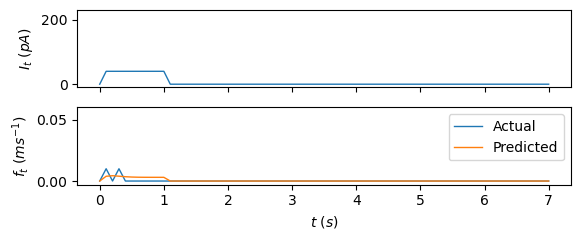

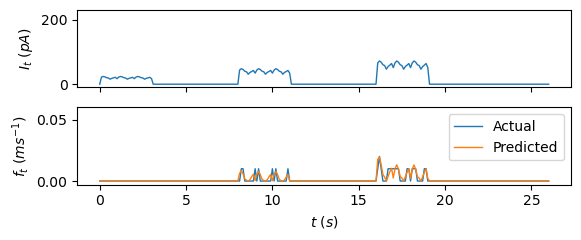

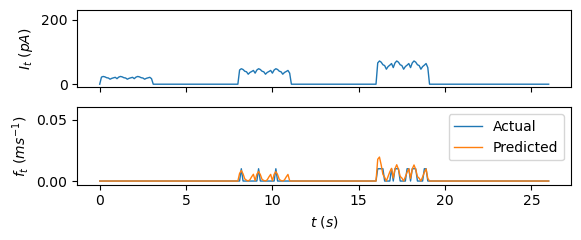

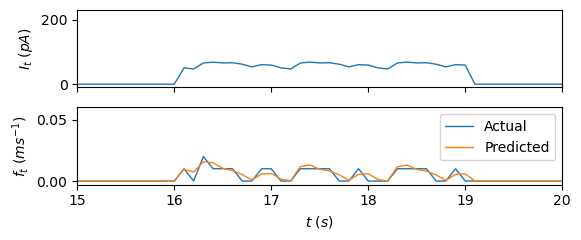

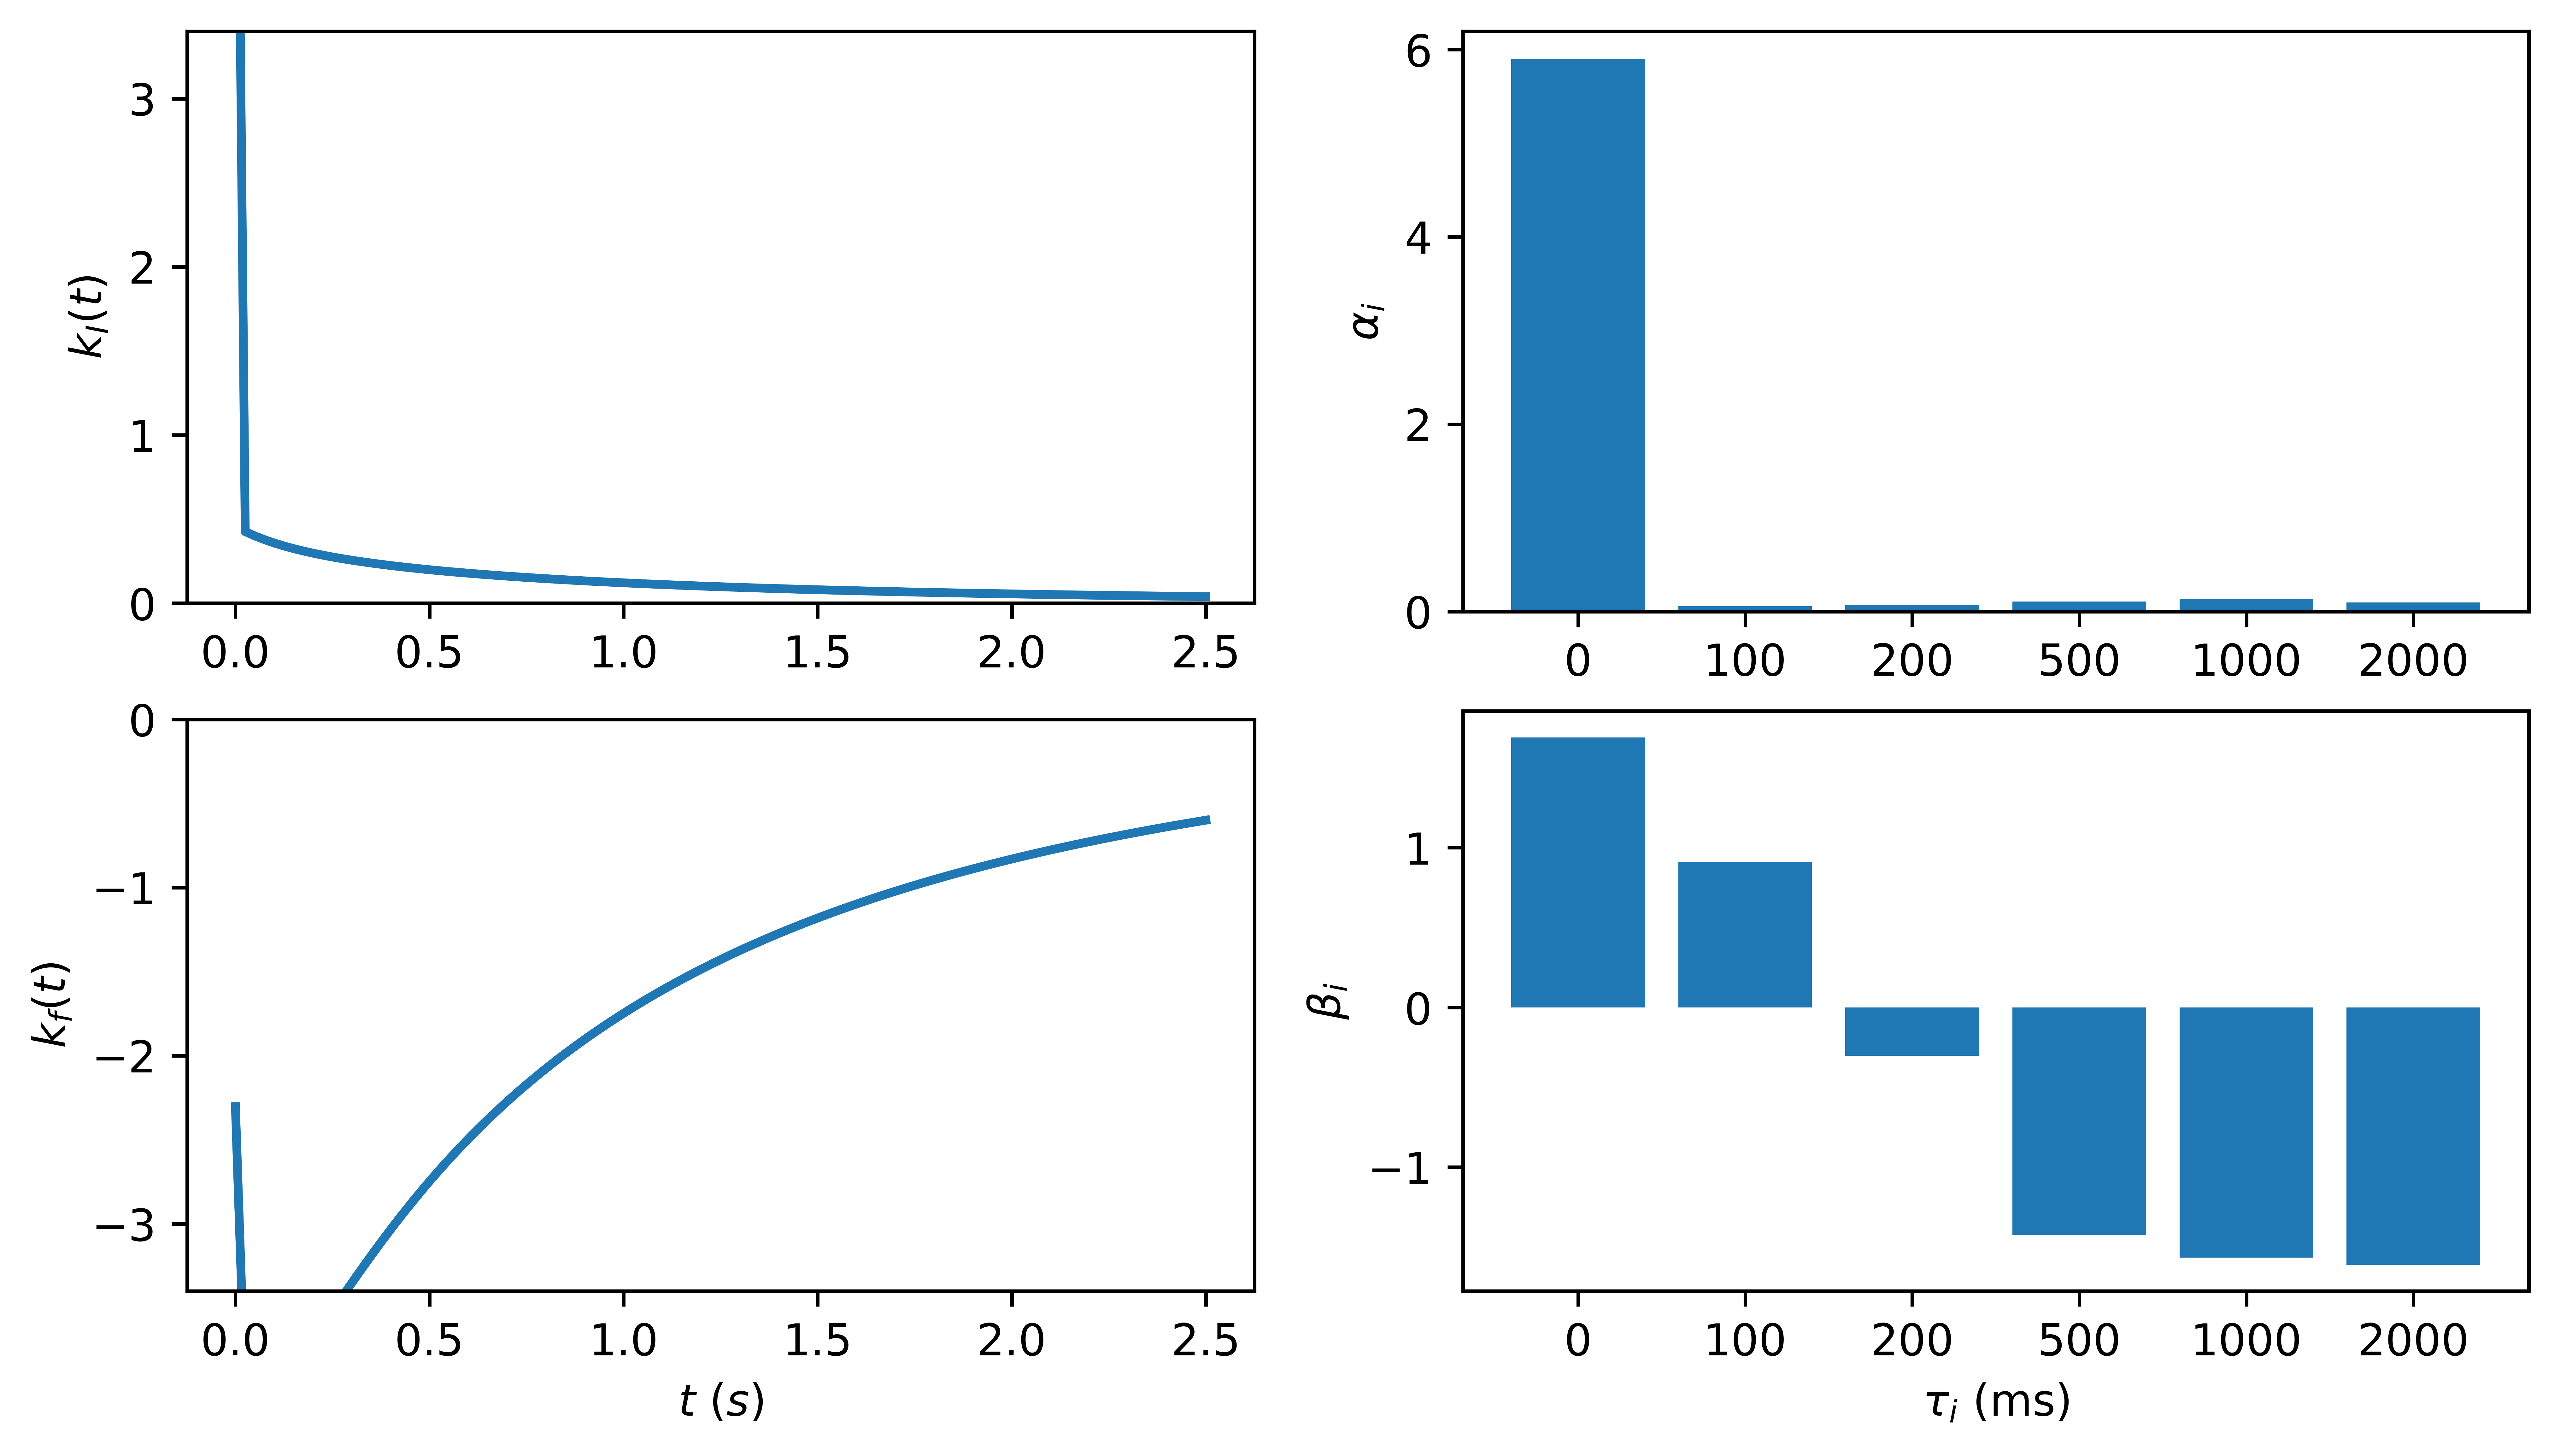

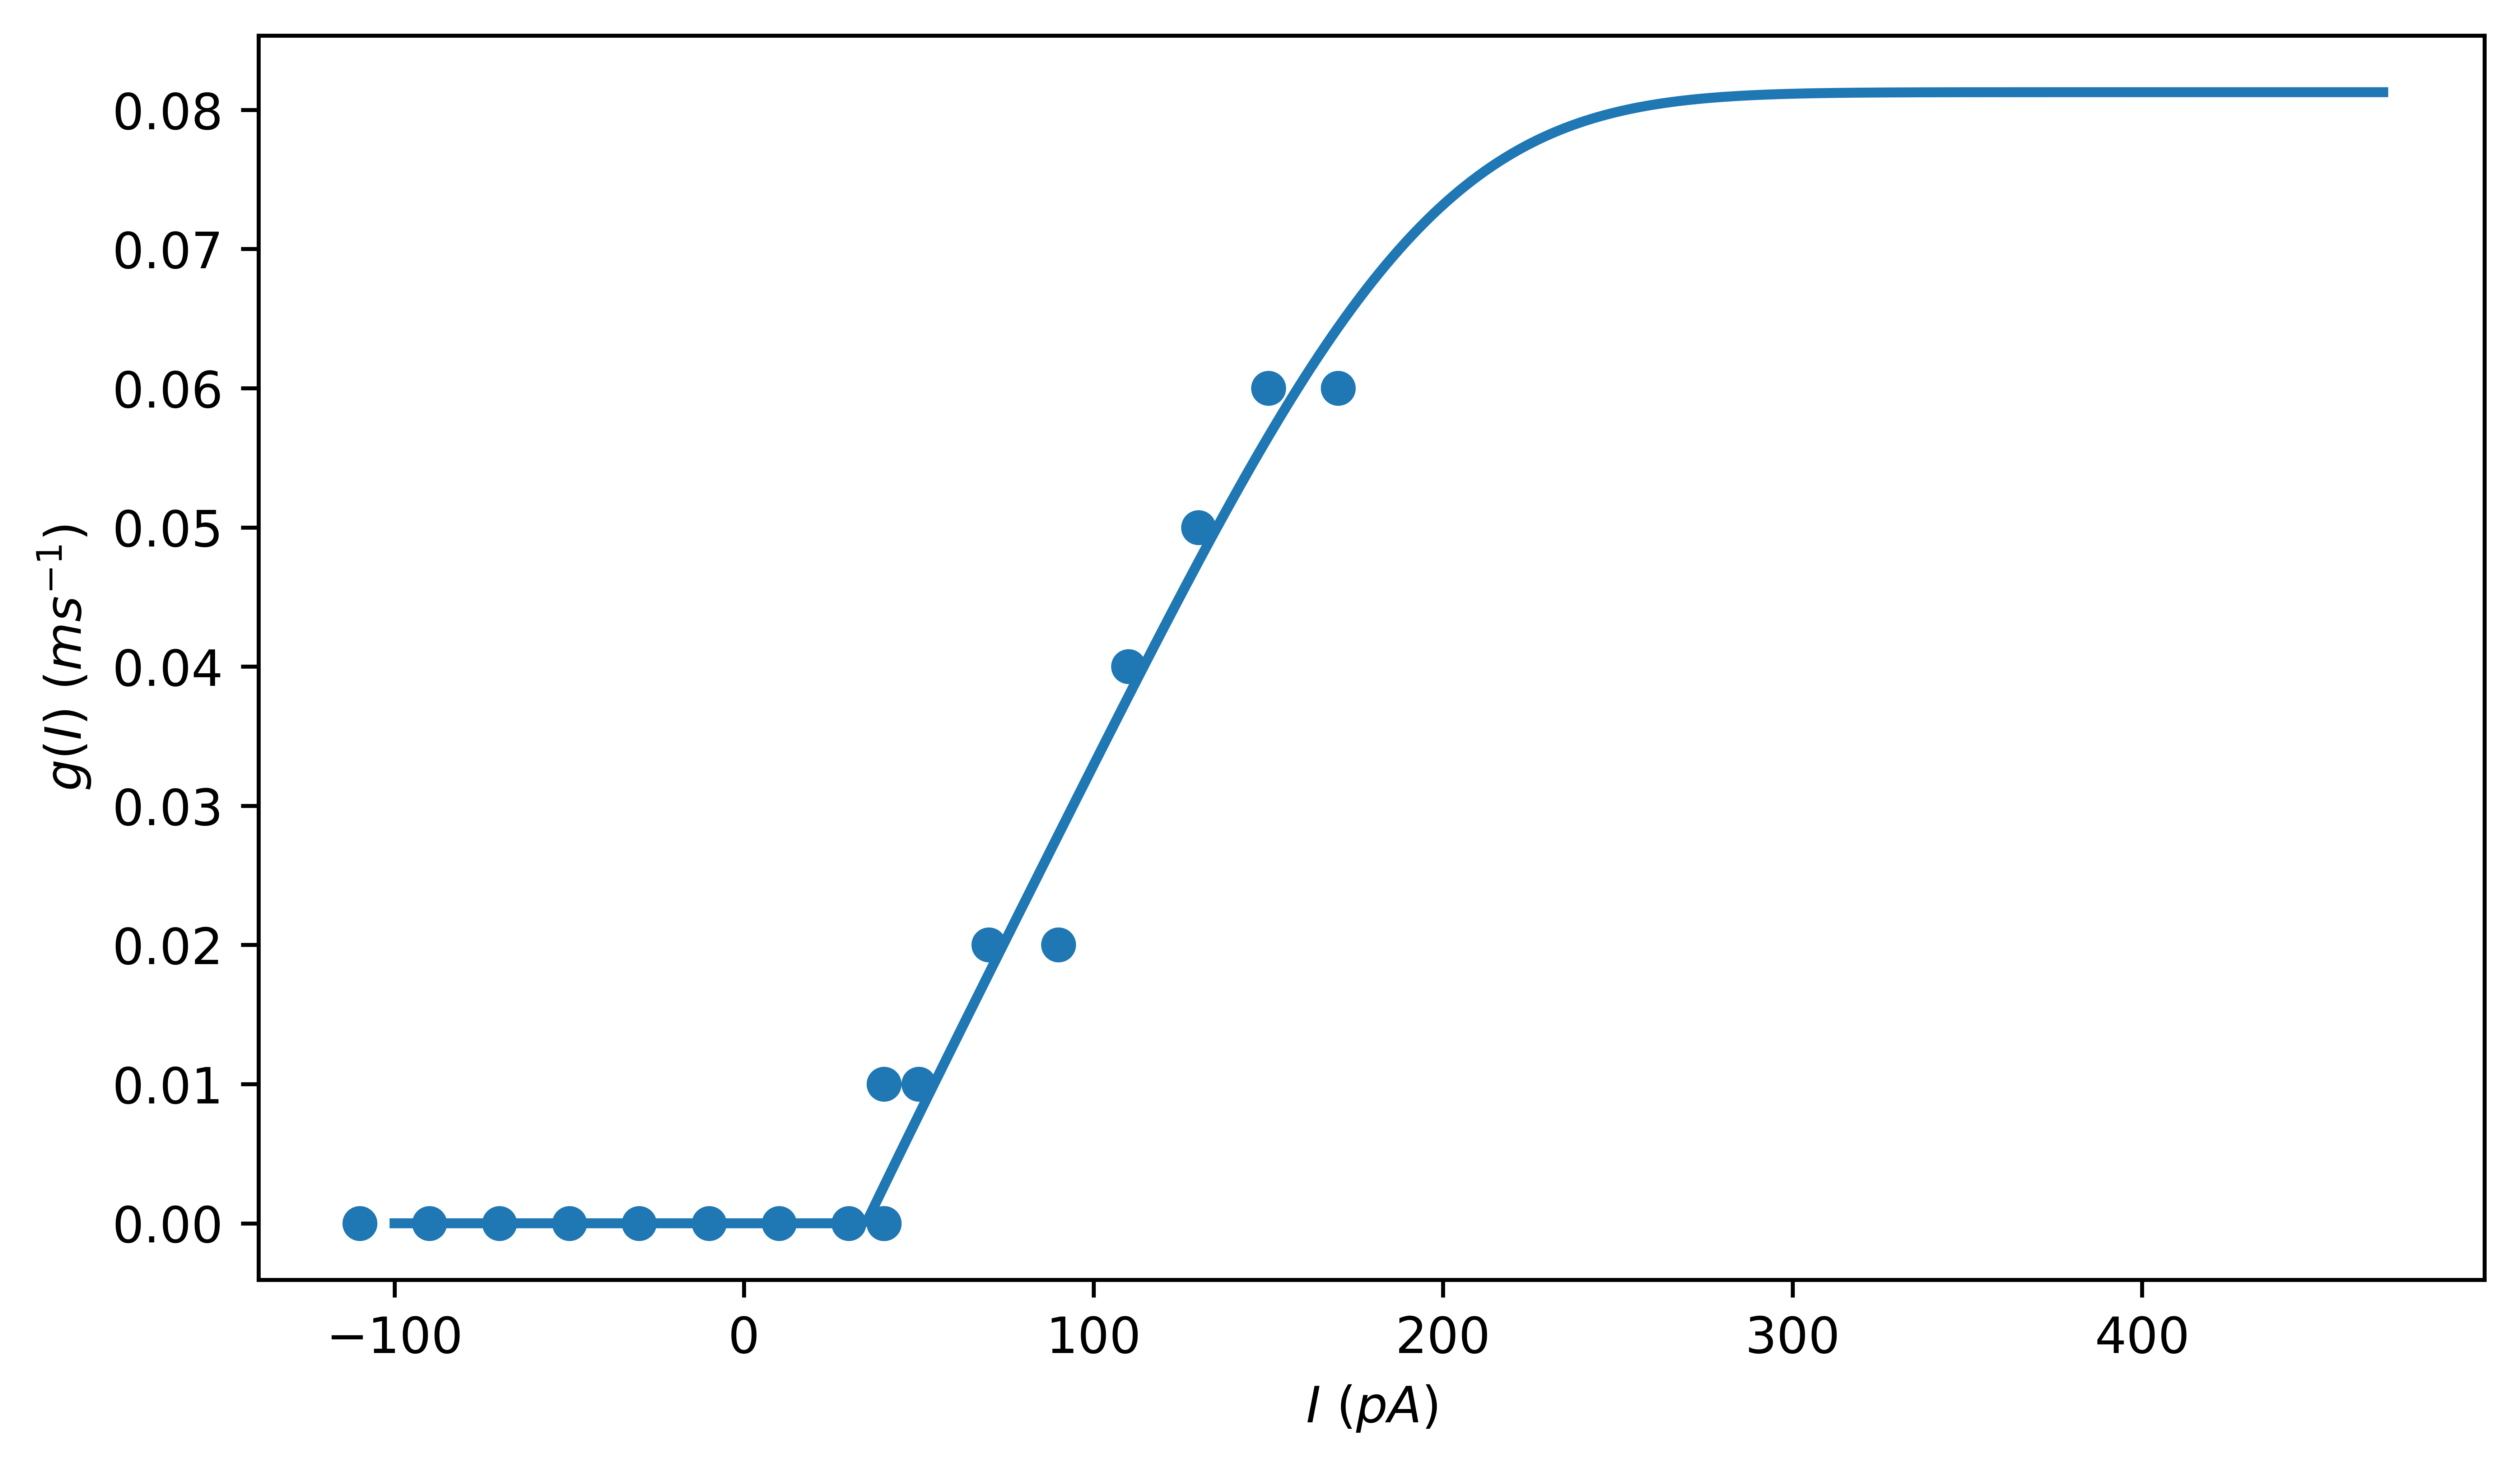

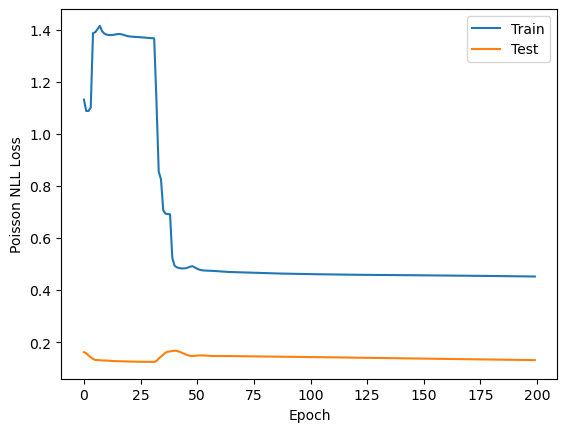

In [7]:
cell_id = 475202388
plt.rcParams.update({'figure.max_open_warning': 0})
visualize(cell_id, params[(bin_size, actv_bin_size)], bin_size)